# **Głębokie Sieci Neuronowe - projekt**
## **Temat:** *Generowanie przebiegów funkcji matematycznych z wykorzystaniem modelu dyfuzyjnego*


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from torch.optim import Adam
import math
import pytorch_lightning as pl


### Opis kodu

1. **Generowanie falek Morleta**:
   - Funkcja `generate_morlet_wavelet` generuje falę Morleta o zadanych parametrach:
     - `frequency` (częstotliwość)
     - `sampling_rate` (częstotliwość próbkowania)
     - `sigma` (rozprzestrzenienie)
     - `amplitude` (amplituda)
   - Czas `t` jest rozłożony liniowo od -1 do 1, a wynikowa fala jest kombinacją sinusoidy i gaussowskiego tłumienia.

2. **Dataset falek Morleta**:
   - Klasa `MorletCleanDataset` tworzy zestaw danych składający się z czystych falek Morleta:
     - Generowane są falki o losowych parametrach (częstotliwość, sigma, amplituda).
     - Falki są przechowywane w liście `samples`.

3. **Harmonogram beta**:
   - Funkcja `linear_beta_schedule` tworzy liniowy harmonogram wartości beta, który służy do stopniowego zaszumiania falek.
     - `timesteps` określa liczbę kroków czasowych.
     - `start` i `end` określają zakres wartości beta.

4. **Funkcja pomocnicza**:
   - Funkcja `get_index_from_list` pobiera wartości z listy w oparciu o indeksy czasowe `t`.



In [3]:
def generate_morlet_wavelet(frequency, sampling_rate, sigma, amplitude=1.0):
    t = np.linspace(-1, 1, 2 * sampling_rate)
    wavelet = amplitude * np.cos(2 * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))
    return wavelet

class MorletCleanDataset(Dataset):
    def __init__(self, num_samples=100, sampling_rate=1000):
        self.samples = []
        self.sampling_rate = sampling_rate
        frequencies = [5, 10, 15, 20, 25]
        sigmas = [0.05, 0.1, 0.15, 0.2]
        amplitudes = [0.5, 1.0, 1.5]

        for _ in range(num_samples):
            freq = np.random.choice(frequencies)
            sigma = np.random.choice(sigmas)
            amplitude = np.random.choice(amplitudes)
            wavelet = generate_morlet_wavelet(freq, sampling_rate, sigma, amplitude)
            self.samples.append(torch.tensor(wavelet, dtype=torch.float32))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx].unsqueeze(0)

class MorletDataModule(pl.LightningDataModule):
    def __init__(self, num_samples=1000, batch_size=128, sampling_rate=1000):
        super().__init__()
        self.num_samples = num_samples
        self.batch_size = batch_size
        self.sampling_rate = sampling_rate

    def setup(self, stage=None):
        self.train_dataset = MorletCleanDataset(num_samples=self.num_samples, sampling_rate=self.sampling_rate)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)

def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu().clamp(max=T-1))
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# Utworzenie datasetu i DataLoadera
clean_dataset = MorletCleanDataset(num_samples=100)  # Generuj 100 czystych próbek
clean_loader = DataLoader(clean_dataset, batch_size=1, shuffle=True)


### Proces zaszumiania (Forward Process)

- Funkcja `forward_diffusion_sample` dodaje szum do czystej fali na podstawie wartości beta i alfa:
- Generuje szum o takiej samej wielkości jak próbka.
- Oblicza skumulowane iloczyny `sqrt_alphas_cumprod_t` i `sqrt_one_minus_alphas_cumprod_t`.
- Zwraca zaszumioną falę oraz szum.

W procesie zaszumiania, próbka w kroku czasowym \( t \) jest generowana z próbki w kroku czasowym \( t-1 \) za pomocą następującego wzoru:

$$
q(\mathbf{x}_t | \mathbf{x}_{t-1}) = \mathcal{N}(\mathbf{x}_t; \sqrt{1 - \beta_t} \mathbf{x}_{t-1}, \beta_t \mathbf{I})
$$

Alternatywnie, zaszumianie można wyrazić w jednym kroku jako:

$$
q(\mathbf{x}_t | \mathbf{x}_0) = \mathcal{N}(\mathbf{x}_t; \sqrt{\bar{\alpha}_t} \mathbf{x}_0, (1 - \bar{\alpha}_t) \mathbf{I})
$$

gdzie:
- $\mathbf{x}_t$ to zaszumiona próbka w kroku czasowym $t$,
- $\beta_t$ to harmonogram zaszumiania,
- $\mathbf{x}_{t-1}$ to próbka z poprzedniego kroku czasowego,
- $\mathbf{I}$ to macierz jednostkowa,
- $\bar{\alpha}_t$ to skumulowany iloczyn wartości $\alpha$ do kroku $t$.


In [4]:
def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
           + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

## Definicja wartości i wizualizacja zaszumionych falek

1. **Definicja wartości**:
   - Zmienna `T` określa liczbę kroków zaszumiania (300).
   - Obliczane są wartości `betas`, `alphas`, `alphas_cumprod`, `sqrt_recip_alphas`, `sqrt_alphas_cumprod`, `sqrt_one_minus_alphas_cumprod` i `posterior_variance`.

- Harmonogram beta:
  $$
  \beta_t = \text{linear_beta_schedule}(\text{timesteps}, \text{start}, \text{end})
  $$

- Alphas:
  $$
  \alpha_t = 1 - \beta_t
  $$

- Skumulowany iloczyn alphas:
  $$
  \bar{\alpha}_t = \prod_{i=1}^t \alpha_i
  $$

- Poprzedni skumulowany iloczyn alphas:
  $$
  \bar{\alpha}_{t-1} = \text{pad}(\bar{\alpha}_t[:-1], (1, 0), \text{value}=1.0)
  $$

- Pierwiastek z odwrotności alphas:
  $$
  \sqrt{\alpha_t^{-1}} = \sqrt{\frac{1}{\alpha_t}}
  $$

- Pierwiastek ze skumulowanego iloczynu alphas:
  $$
  \sqrt{\bar{\alpha}_t} = \sqrt{\prod_{i=1}^t \alpha_i}
  $$

- Pierwiastek z 1 minus skumulowany iloczyn alphas:
  $$
  \sqrt{1 - \bar{\alpha}_t} = \sqrt{1 - \prod_{i=1}^t \alpha_i}
  $$

- Wariancja posterior:
  $$
  \text{posterior_variance}_t = \beta_t \cdot \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t}
  $$

2. **Wizualizacja zaszumionych falek**:
- Funkcja `plot_noisy_wavelets` wizualizuje czystą falę oraz zaszumione wersje fali w różnych krokach czasowych.
- Wywołanie funkcji `plot_noisy_wavelets` pokazuje czystą falę oraz jej wersje zaszumione w krokach czasowych.


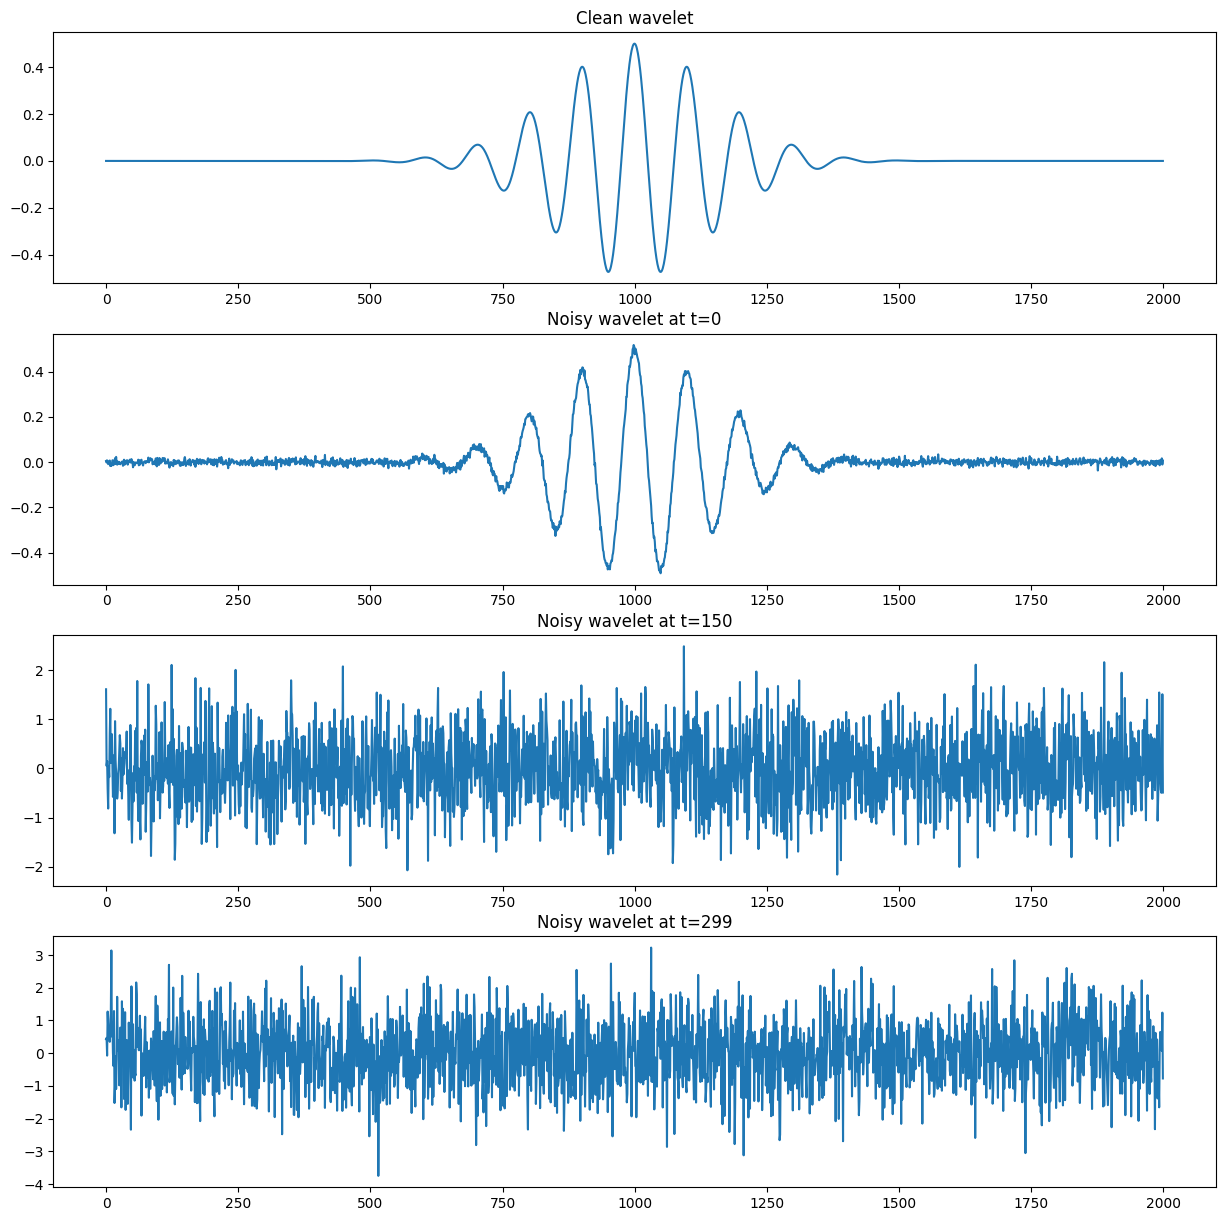

In [5]:
T = 300
betas = linear_beta_schedule(timesteps=T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

@torch.no_grad()
def plot_noisy_wavelets(sample, T, device):
    sample = sample.unsqueeze(0).to(device)
    timesteps = [0, T // 2, T - 1]

    plt.figure(figsize=(15, 5 * len(timesteps)))

    plt.subplot(len(timesteps) + 1, 1, 1)
    plt.plot(sample.cpu().squeeze().numpy())
    plt.title(f"Clean wavelet")

    for i, t in enumerate(timesteps):
        t_tensor = torch.full((1,), t, device=device, dtype=torch.long)
        noisy_wavelet, _ = forward_diffusion_sample(sample, t_tensor, device)
        plt.subplot(len(timesteps) + 1, 1, i + 2)
        plt.plot(noisy_wavelet.cpu().squeeze().numpy())
        plt.title(f"Noisy wavelet at t={t}")

    plt.show()


# Definiowanie zmiennej `device`
device = "cuda" if torch.cuda.is_available() else "cpu"

# Wywołanie funkcji plot_noisy_wavelets, aby sprawdzić poprawność
sample_idx = 0
plot_noisy_wavelets(clean_dataset[sample_idx], T, device)

## Definicja i inicjalizacja modelu

Ten segment kodu definiuje i inicjalizuje model dyfuzyjny oparty na sieci U-Net, który jest używany do przewidywania szumu w zaszumionych danych falek Morleta.

#### Klasa `Block`
- Zawiera warstwy konwolucyjne, normalizację wsadową (batch normalization) i funkcję aktywacji ReLU.
- Może wykonywać operacje zmniejszania rozdzielczości (downsampling) lub zwiększania rozdzielczości (upsampling).

#### Klasa `SinusoidalPositionEmbeddings`
- Generuje sinusoidalne osadzenia pozycyjne, które są używane do zakodowania informacji o czasie.

#### Klasa `SimpleUnet`
- Implementuje uproszczoną sieć U-Net.
- Zawiera warstwy konwolucyjne, warstwy downsamplingu i upsamplingu oraz warstwę wyjściową.
- Używa osadzeń czasowych do przetwarzania danych wejściowych.

#### Inicjalizacja modelu
- Model U-Net (`SimpleUnet`) jest inicjalizowany i przenoszony na dostępne urządzenie obliczeniowe (CPU lub GPU).
- Inicjalizowany jest również optymalizator Adam z domyślnym współczynnikiem uczenia wynoszącym 0.001.


In [10]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)

        if up:
            self.conv1 = nn.Conv1d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose1d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv1d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv1d(out_ch, out_ch, 4, 2, 1)

        self.conv2 = nn.Conv1d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm1d(out_ch)
        self.bnorm2 = nn.BatchNorm1d(out_ch)
        self.relu = nn.ReLU()

    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[..., None]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(pl.LightningModule):
    def __init__(self):
        super().__init__()
        wavelet_channels = 1
        down_channels = (64, 128, 256, 512)
        up_channels = (512, 256, 128, 64)
        out_dim = 1
        time_emb_dim = 32

        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )

        self.conv0 = nn.Conv1d(wavelet_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], time_emb_dim) for i in range(len(down_channels)-1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], time_emb_dim, up=True) for i in range(len(up_channels)-1)])
        self.output = nn.Conv1d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []

        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)

        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)

        return self.output(x)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=0.001)

    def training_step(self, batch, batch_idx):
        t = torch.randint(0, T, (batch.size(0),), device=self.device).long()
        loss = self.get_loss(batch, t)
        self.log('train_loss', loss)
        return loss

    def get_loss(self, x_0, t):
        x_noisy, noise = forward_diffusion_sample(x_0, t, self.device)
        noise_pred = self(x_noisy, t)
        return F.mse_loss(noise, noise_pred)
    
    def on_epoch_end(self):
        self.sample_plot_wavelet()

    @torch.no_grad()
    def sample_plot_wavelet(self):
        wavelet_size = 256
        sampling_rate = wavelet_size // 2

        frequency = np.random.choice([5, 10, 15, 20, 25])
        sigma = np.random.choice([0.05, 0.1, 0.15, 0.2])
        amplitude = np.random.choice([0.5, 1.0, 1.5])
        t = np.linspace(-1, 1, wavelet_size)
        clean_wavelet = amplitude * np.cos(2 * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))
        clean_wavelet = torch.tensor(clean_wavelet, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)

        '''
        plt.figure(figsize=(15, 15))
        plt.axis('off')
        num_samples = 10

        plt.subplot(num_samples + 1, 1, 1)
        plt.plot(clean_wavelet.cpu().squeeze().numpy())
        plt.title("Clean wavelet")

        for i in range(1, num_samples + 1):
            t = torch.full((1,), T * i // num_samples, device=self.device, dtype=torch.long)
            noisy_wavelet, _ = forward_diffusion_sample(clean_wavelet, t)
            plt.subplot(num_samples + 1, 1, i + 1)
            plt.plot(noisy_wavelet.cpu().squeeze().numpy())
            plt.title(f"Noisy wavelet at t={T * i // num_samples}")

        plt.show()
        '''
    @torch.no_grad()
    def sample_timestep(self, x, t):
        betas_t = get_index_from_list(betas, t, x.shape)
        sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
        sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
        model_mean = sqrt_recip_alphas_t * (x - betas_t * self(x, t) / sqrt_one_minus_alphas_cumprod_t)
        posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

        if t == 0:
            return model_mean
        else:
            noise = torch.randn_like(x)
            return model_mean + torch.sqrt(posterior_variance_t) * noise

    @torch.no_grad()
    def generate_and_denoise_wavelets(self, num_examples=5):
        wavelet_size = 256
        T = 300
        frequencies = [5, 10, 15, 20, 25]
        sigmas = [0.05, 0.1, 0.15, 0.2]
        amplitudes = [0.5, 1.0, 1.5]

        plt.figure(figsize=(15, 5 * num_examples))

        for example_idx in range(num_examples):
            t = np.linspace(-1, 1, wavelet_size)
            freq = np.random.choice(frequencies)
            sigma = np.random.choice(sigmas)
            amplitude = np.random.choice(amplitudes)
            new_wavelet = generate_morlet_wavelet(freq, 1000, sigma, amplitude)
            new_wavelet_tensor = torch.tensor(new_wavelet, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(self.device)

            t = torch.randint(0, T, (1,), device=self.device).long()
            noisy_wavelet, noise = forward_diffusion_sample(new_wavelet_tensor, t, self.device)

            with torch.no_grad():
                predicted_wavelet = new_wavelet_tensor.clone()
                for i in range(T-1, -1, -1):
                    t = torch.full((1,), i, device=self.device, dtype=torch.long)
                    predicted_wavelet = self.sample_timestep(predicted_wavelet, t)

            plt.subplot(num_examples, 3, example_idx * 3 + 1)
            plt.title(f"Original Wavelet {example_idx + 1}")
            plt.plot(new_wavelet)

            plt.subplot(num_examples, 3, example_idx * 3 + 2)
            plt.title(f"Noisy Wavelet {example_idx + 1}")
            plt.plot(noisy_wavelet.cpu().squeeze().numpy())

            plt.subplot(num_examples, 3, example_idx * 3 + 3)
            plt.title(f"Denoised Wavelet {example_idx + 1}")
            plt.plot(predicted_wavelet.cpu().squeeze().numpy())

        plt.tight_layout()
        plt.show()


## Funkcja straty (Simple Loss)

Strata jest obliczana jako średni błąd kwadratowy (MSE) między faktycznym szumem a szumem przewidywanym przez model. Wzór na stratę to:

$$
\mathcal{L}_{\text{simple}} = \mathbb{E}_{t, \mathbf{x}_0, \mathbf{\epsilon}} \left[ \left\| \mathbf{\epsilon} - \mathbf{\epsilon}_\theta(\mathbf{x}_t, t) \right\|^2 \right]
$$

gdzie:
- $\mathbf{\epsilon}$ to faktyczny szum dodany do próbki,
- $\mathbf{\epsilon}_\theta(\mathbf{x}_t, t)$ to szum przewidywany przez model.

W kodzie, funkcja straty jest zaimplementowana w funkcji `get_loss` jako MSE. Oto jak to wygląda:


`x_noisy, noise = forward_diffusion_sample(x_0, t, device)` generuje zaszumioną próbkę i oryginalny szum.

`noise_pred = model(x_noisy, t)` przewiduje szum za pomocą modelu.

`return F.mse_loss(noise, noise_pred)` oblicza stratę MSE między faktycznym szumem a przewidywanym szumem.



## Generowanie i wizualizacja falek Morleta

Ten fragment kodu zawiera dwie główne funkcje do próbkowania i wizualizacji falek Morleta w różnych etapach procesu zaszumiania:

#### Funkcja `sample_timestep`
- **Opis**: Generuje próbkę fali na danym kroku czasowym t, odwracając proces zaszumiania.
- **Działanie**:
  - Pobiera odpowiednie wartości parametrów dyfuzyjnych dla danego kroku czasowego.
  - Oblicza średnią modelu (model mean) dla próbki.
  - Dodaje szum na podstawie wariancji posterior, chyba że jest to krok 0, wtedy zwraca tylko model mean.

#### Funkcja `sample_plot_wavelet`
- **Opis**: Generuje i wyświetla czystą falę Morleta oraz jej zaszumione wersje na różnych etapach procesu zaszumiania.
- **Działanie**:
  - Generuje losową czystą falę Morleta z wybranymi parametrami.
  - Wyświetla czystą falę na górze wykresu.
  - Generuje i wyświetla zaszumione wersje fali na kolejnych krokach czasowych.

### Wywołanie funkcji
- `sample_plot_wavelet()`: Funkcja jest wywoływana w celu sprawdzenia poprawności procesu zaszumiania i wizualizacji wyników.


In [7]:
@torch.no_grad()
def sample_timestep(x, t):
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    model_mean = sqrt_recip_alphas_t * (x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t)
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)

    if t == 0:
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise


@torch.no_grad()
def sample_plot_wavelet(model, device):
    wavelet_size = 256
    sampling_rate = wavelet_size // 2

    frequency = np.random.choice([5, 10, 15, 20, 25])
    sigma = np.random.choice([0.05, 0.1, 0.15, 0.2])
    amplitude = np.random.choice([0.5, 1.0, 1.5])
    t = np.linspace(-1, 1, wavelet_size)
    clean_wavelet = amplitude * np.cos(2 * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))
    clean_wavelet = torch.tensor(clean_wavelet, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

    plt.figure(figsize=(15, 15))
    plt.axis('off')
    num_samples = 10

    plt.subplot(num_samples + 1, 1, 1)
    plt.plot(clean_wavelet.cpu().squeeze().numpy())
    plt.title("Clean wavelet")

    for i in range(1, num_samples + 1):
        t = torch.full((1,), T * i // num_samples, device=device, dtype=torch.long)
        noisy_wavelet, _ = forward_diffusion_sample(clean_wavelet, t)
        plt.subplot(num_samples + 1, 1, i + 1)
        plt.plot(noisy_wavelet.cpu().squeeze().numpy())
        plt.title(f"Noisy wavelet at t={T * i // num_samples}")

    plt.show()


'\n@torch.no_grad()\ndef sample_plot_wavelet(model, device):\n    wavelet_size = 256\n    sampling_rate = wavelet_size // 2\n\n    frequency = np.random.choice([5, 10, 15, 20, 25])\n    sigma = np.random.choice([0.05, 0.1, 0.15, 0.2])\n    amplitude = np.random.choice([0.5, 1.0, 1.5])\n    t = np.linspace(-1, 1, wavelet_size)\n    clean_wavelet = amplitude * np.cos(2 * np.pi * frequency * t) * np.exp(-t**2 / (2 * sigma**2))\n    clean_wavelet = torch.tensor(clean_wavelet, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)\n\n    plt.figure(figsize=(15, 15))\n    plt.axis(\'off\')\n    num_samples = 10\n\n    plt.subplot(num_samples + 1, 1, 1)\n    plt.plot(clean_wavelet.cpu().squeeze().numpy())\n    plt.title("Clean wavelet")\n\n    for i in range(1, num_samples + 1):\n        t = torch.full((1,), T * i // num_samples, device=device, dtype=torch.long)\n        noisy_wavelet, _ = forward_diffusion_sample(clean_wavelet, t)\n        plt.subplot(num_samples + 1, 1, i + 1)\n        p

## Inicjalizacja i trenowanie modelu

#### Inicjalizacja nowego zbioru danych i modelu
- Tworzenie nowego zbioru danych `MorletCleanDataset` z 1000 próbek falek Morleta o częstotliwości próbkowania 1000.
- Inicjalizacja DataLoadera do ładowania danych w partiach po 128, z losowym mieszaniem i odrzucaniem ostatniej niepełnej partii.

#### Trenowanie modelu
- Model jest trenowany przez 500 epok.
- Dla każdej epoki:
  - Inicjalizacja zmiennej `epoch_loss` do przechowywania straty dla danej epoki.
  - Iteracja przez partie danych z DataLoadera.
  - Zerowanie gradientów optymalizatora.
  - Losowe wybieranie kroków czasowych `t`.
  - Obliczanie straty za pomocą funkcji `get_loss`.
  - Propagacja wsteczna strat (backpropagation) i aktualizacja wag modelu.
  - Sumowanie strat dla danej epoki.
  - Wydrukowanie aktualnej straty co 100 kroków.
- Po zakończeniu każdej epoki, średnia strata dla epoki jest dodawana do listy `losses`.
- Co 5 epok, wywoływana jest funkcja `sample_plot_wavelet`, aby zwizualizować odszumiane falki.

#### Wykres strat
- Po zakończeniu trenowania, tworzony jest wykres przedstawiający zmiany funkcji strat podczas treningu.



## Faza testowania modelu

#### Funkcja `generate_and_denoise_wavelets`
- **Opis**: Generuje nowe falki Morleta, zaszumiane i odszumiane przez model, a następnie wyświetla wyniki.
- **Parametry**:
  - `model`: wytrenowany model do odszumiania falek.
  - `device`: urządzenie obliczeniowe (CPU lub GPU).
  - `num_examples`: liczba przykładów do wygenerowania i odszumienia (domyślnie 5).
- **Działanie**:
  - Dla każdej falki:
    - Generuje nową falę Morleta z losowymi parametrami (częstotliwość, sigma, amplituda).
    - Zaszumia falę za pomocą funkcji `forward_diffusion_sample`.
    - Przeprowadza proces odszumiania za pomocą modelu, iterując od najbardziej zaszumionej wersji do czystej fali.
    - Wyświetla oryginalną falę, zaszumioną falę oraz odszumioną falę w jednym wierszu wykresu.

#### Wizualizacja wyników
- **Wizualizacja**:
  - Każdy przykład zawiera trzy wykresy: oryginalna fala, zaszumiona fala i odszumiona fala.


In [8]:
def generate_and_denoise_wavelets(model, device, num_examples=5):
    wavelet_size = 256
    T = 300
    frequencies = [5, 10, 15, 20, 25]
    sigmas = [0.05, 0.1, 0.15, 0.2]
    amplitudes = [0.5, 1.0, 1.5]

    plt.figure(figsize=(15, 5 * num_examples))

    for example_idx in range(num_examples):
        t = np.linspace(-1, 1, wavelet_size)
        freq = np.random.choice(frequencies)
        sigma = np.random.choice(sigmas)
        amplitude = np.random.choice(amplitudes)
        new_wavelet = generate_morlet_wavelet(freq, 1000, sigma, amplitude)
        new_wavelet_tensor = torch.tensor(new_wavelet, dtype=torch.float32).unsqueeze(0).unsqueeze(0).to(device)

        t = torch.randint(0, T, (1,), device=device).long()
        noisy_wavelet, noise = forward_diffusion_sample(new_wavelet_tensor, t, device)

        with torch.no_grad():
            predicted_wavelet = new_wavelet_tensor.clone()
            for i in range(T-1, -1, -1):
                t = torch.full((1,), i, device=device, dtype=torch.long)
                predicted_wavelet = sample_timestep(predicted_wavelet, t)

        plt.subplot(num_examples, 3, example_idx * 3 + 1)
        plt.title(f"Original Wavelet {example_idx + 1}")
        plt.plot(new_wavelet)

        plt.subplot(num_examples, 3, example_idx * 3 + 2)
        plt.title(f"Noisy Wavelet {example_idx + 1}")
        plt.plot(noisy_wavelet.cpu().squeeze().numpy())

        plt.subplot(num_examples, 3, example_idx * 3 + 3)
        plt.title(f"Denoised Wavelet {example_idx + 1}")
        plt.plot(predicted_wavelet.cpu().squeeze().numpy())

    plt.tight_layout()
    plt.show()


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name     | Type       | Params
----------------------------------------
0 | time_mlp | Sequential | 1 K   
1 | conv0    | Conv1d     | 256   
2 | downs    | ModuleList | 2 M   
3 | ups      | ModuleList | 1 M   
4 | output   | Conv1d     | 65    


Epoch 4: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s, loss=0.051, v_num=1]


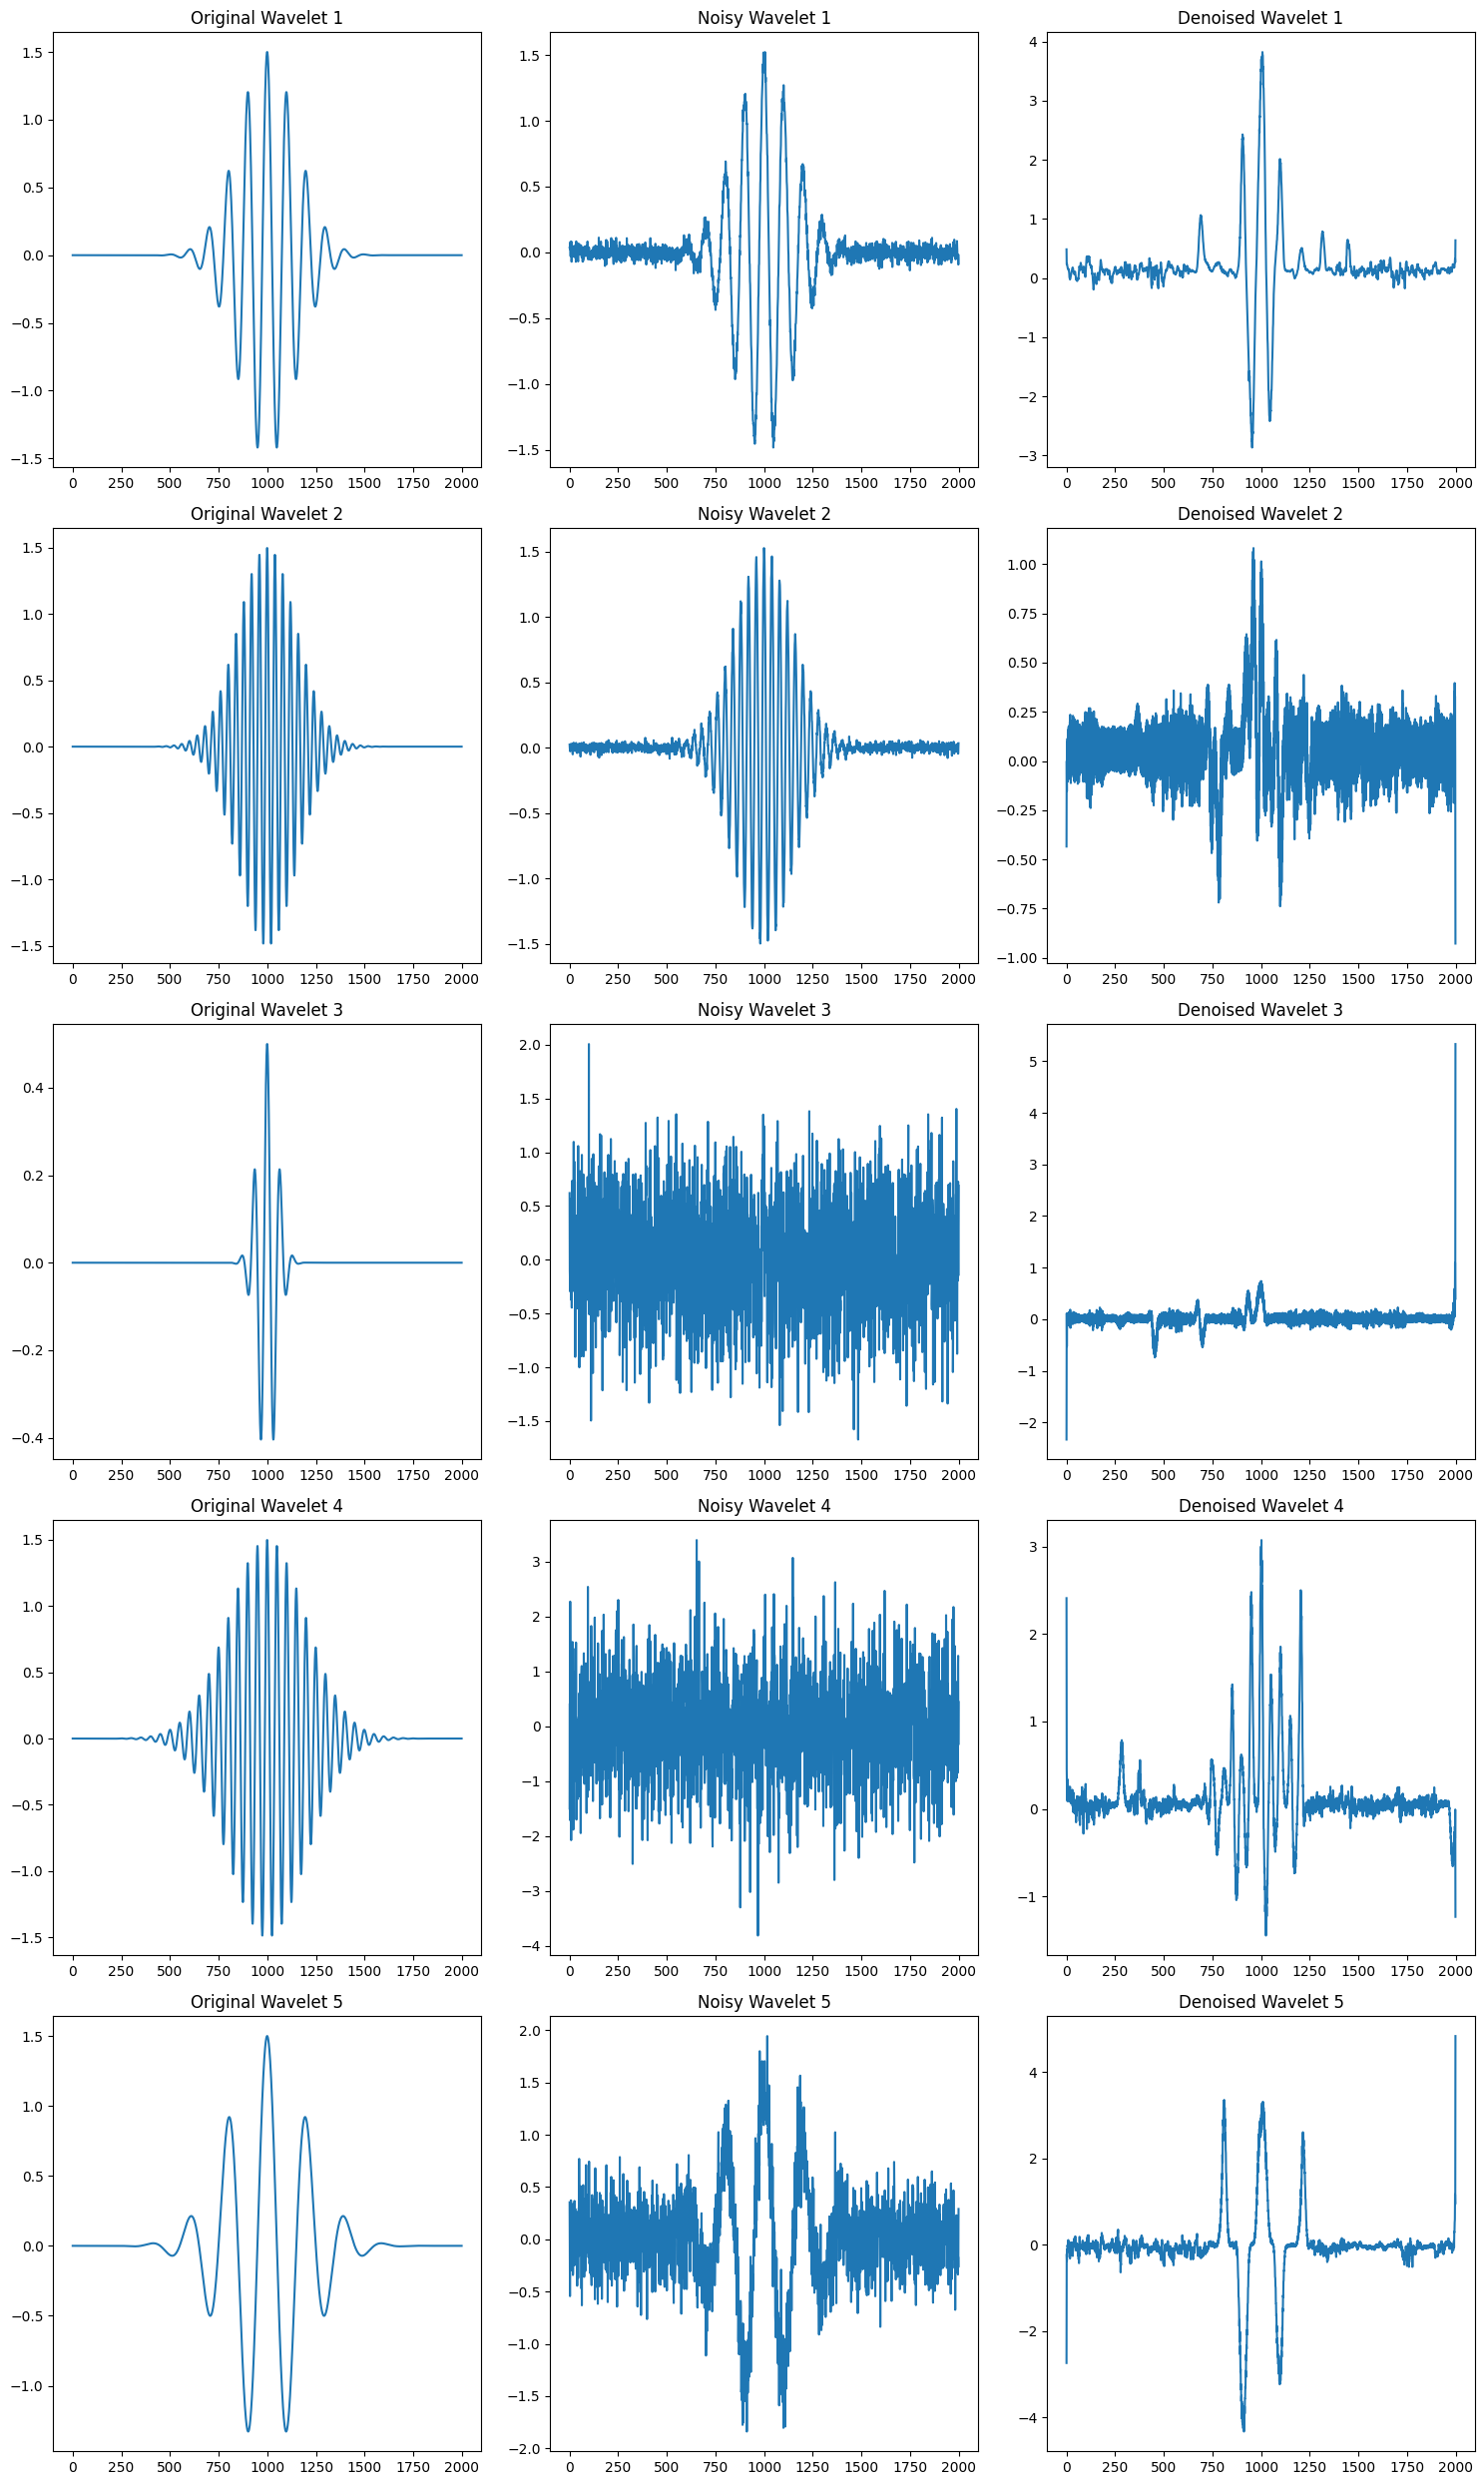

In [11]:
data_module = MorletDataModule(num_samples=1000, batch_size=128, sampling_rate=1000)
model = SimpleUnet()

trainer = pl.Trainer(max_epochs=50, gpus=1 if torch.cuda.is_available() else 0)
trainer.fit(model, data_module)

# Wywołanie funkcji generowania i odszumiania falek po treningu
model.generate_and_denoise_wavelets()


## Wnioski z eksperymentu generowania i odszumiania falek Morleta

#### Generowanie falek Morleta
- **Oryginalne falki** (lewa kolumna): Falki Morleta zostały wygenerowane z losowymi parametrami (częstotliwość, sigma, amplituda). Są one wyraźne i mają charakterystyczny kształt.

#### Proces zaszumiania
- **Zaszumione falki** (środkowa kolumna): Zaszumiane wersje falek są silnie zniekształcone. Szum został dodany losowo, co sprawia, że oryginalny kształt fali jest trudny do rozpoznania.

#### Odszumianie za pomocą modelu dyfuzyjnego
- **Odszumione falki** (prawa kolumna): Model dyfuzyjny stara się odtworzyć oryginalny kształt fali z zaszumionej wersji. Wyniki pokazują, że model jest w stanie częściowo odszumić falki, ale nadal pozostają pewne artefakty szumu.

#### Wnioski:
1. **Skuteczność modelu dyfuzyjnego**: Model dyfuzyjny jest w stanie przybliżyć oryginalne falki z zaszumionych wersji, co świadczy o jego skuteczności. Jednakże, odszumione falki nie są idealnie czyste i zawierają pewne artefakty szumu.
2. **Parametry falek**: Różne parametry generowania falek (częstotliwość, sigma, amplituda) wpływają na kształt odszumionych falek. Niektóre falki są odszumiane lepiej niż inne.
3. **Potrzeba dalszego ulepszania**: Aby uzyskać lepsze wyniki, można eksperymentować z różnymi hiperparametrami modelu oraz poprawić algorytm odszumiania.

### Podsumowanie
Eksperyment pokazuje, że model dyfuzyjny może być używany do odszumiania falek Morleta, choć wyniki nie są jeszcze idealne. Dalsze badania i ulepszanie modelu mogą prowadzić do lepszych rezultatów w przyszłości.
